# Oracle design #

A characteristic element of the many quantum algorithms as Deutsch-Josza, Grover's search, and amplitude amplification is the presence of **oracles** in their associated circuits. An oracle can be seen a "black box" operation which defines a map from inputs to outputs. It is implemented as a **unitary evolution** which modifies the state vector of its input quantum registers.

Oracles can be of two different types:

* Boolean oracle $O_f$, receiving two non-entangled quantum registers $\left \vert x \right >$ and $\left \vert y \right >$, with $x \in \{ 0,1 \}^n$ and $y \in \{ 0,1 \}^m$ and providing an output

$$O_f \left( \left \vert x \right > \otimes \left \vert y \right > \right) = \left \vert x \right > \otimes \left( \left \vert y \right > \oplus f(x) \right) $$.

* Phase oracle $P_f$, which eventually applies a phase to the input $\left \vert x \right >$, according to the value of a function $f(x)$ with a certain input $\left \vert x \right >$

$$P_f \left \vert x \right > = (-1)^{f(x)} \left \vert x \right >$$.

The previously mentioned algorithms usually employ phase oracles for labelling the solutions of the problem.
In this notebook, an introduction to oracle design which can be employed in quantum algorithms is presented. The first part concerns the design of Boolean oracles, then the notions acquired can be exploited for learning how to design phase oracles.

In [1]:
from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Boolean oracles ##

The development of digital electronics and classical computers has received a fundamental contribution by the so-called **Boolean algebra**, introduced by George Boole in *The Mathematical Analysis of Logic* in 1847, whose main characteristic is that the values of the variables are the truth values true and false. Suffice it to say that the Artithmetic-Logic Unit (ALU), the computational core of all microprocessors, is based on Boolean algebra and its operations.

In this section a brief presentation of how Boolean functions can be designed on classical computers. Then a generic methodology for the design of Boolean oracles on quantum computers will be presented.

### Boolean operations, functions and truth tables ###

It is important to precise at this point that truth and false values of Boolean algenra are usually represented in terms of values 1 and 0 respectively. The three fundamental operations of Boolean logic are:

* **NOT** (negation), involving one operand $x$. The effect of negation is changing the input value, *i.e.*

$$\overline{x} = \begin{cases}
1 & \mbox{if } x = 0 \\
0 & \mbox{if } x = 1
\end{cases}
$$

* **AND** (conjunction), involving two operands $x$ and $y$. The AND operation result is true if and only if all of its operands are true. It is mathemetically equivalent to the multiplication.

$$x \cdot y = \begin{cases}
1 & \mbox{if } x = y = 1 \\
0 & \mbox{otherwise}
\end{cases}
$$

* **OR** (disjunction), involving two operands $x$ and $y$. The OR operation result true if and only if one or more of its operands is true, *i.e.*

$$x + y = \begin{cases}
0 & \mbox{if } x = y = 0 \\
1 & \mbox{otherwise}
\end{cases}
$$

It is possible to prove that a subset of operations containing NOT and one among AND and OR is sufficient for implementing all the operations of Boolean algebra. This is strictly related to the so-called De Morgan's laws, which provide a relationship between the three operations:

$$\begin{array}{l}
x + y = \overline{ \bar{x} \cdot \bar{y} } \\
x \cdot y = \overline{ \bar{x} + \bar{y} }
\end{array}
$$

In addition to the previous operations, it is convenient to introduce a fourth operation: the **exclusive-OR** (usually abbreviated as **XOR**), involving two operands. Differently from the OR operation, characterized by inclusion, XOR excludes the possibility of both $x$ and $y$ being true. It can be seen - in terms of arithmetic - as an addition $\mod 2$, where $1 + 1 = 0$ or - in true-false terms - as an operation which provides a true result when the two operators are not equal. XOR can be written in terms of the fundamental operations as

$$x \oplus y = \left( \overline{x} \cdot y \right) + \left( x \cdot \overline{y} \right)$$

Two important equivalences of XOR gate to be reminded are $0 \oplus x = x$ and $1 \oplus x = \overline{x}$.

These operations are the computational cores of the so-called **Boolean or switching functions**, having the form $f : B^k \rightarrow B $, where $B = \{ 0, 1 \} $ is a **Boolean domain** and $ k \in \mathbf{N} \setminus \{ 0 \}$ is the number of arguments or operands that the function takes. For a given domain $B^k$, Boolean functions can be written in terms of $k$ variables $x_1, x_2, \cdots , x_k$ and Boolean operations. Examples of Boolean functions are:

$$\begin{array}{l}
f(x) = \left( \overline{x}_0 + x_1 \right) \cdot x_2 \\
f(x) = \overline{ {x_0} + {x_1} } \cdot (x_2 \oplus x_3) \\
f(x) = x_0 \cdot \overline{x}_2 + x_1
\end{array}
$$

It is important to observe that - similarly to elementary algebra - the first operations to be done are the "multiplications" (AND), then the "additions" (OR or XOR).

Any Boolean function can be reperesented as a **truth table**, setting out the results of the logical expression for each combination of values of the input variables. A generic truth table presents $k + m$ columns, where $k$ and $m$ are the numbers of input and output variables respectively, and $2^k$ rows, which is equal to the number of combinations of the $k$ inputs. Examples of truth tables are reported in the following.


$$ f(x) = x_0 \cdot x_1 $$
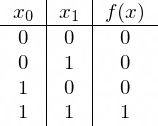


$$ f(x) = x_0 + x_1 $$
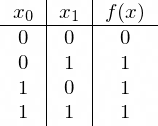


$$f(x) = x_0 \oplus x_1$$
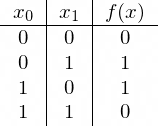

$$\begin{array}{l}
f_1(x) = \overline{x}_2 + x_1 \cdot \overline{x}_0 \\
f_2(x) = x_0 \cdot \overline{x}_2 \oplus x_1
\end{array}
$$
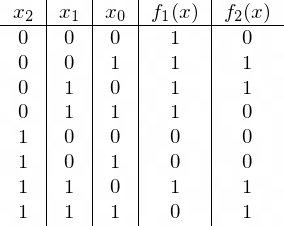

If a truth table is available, it is possible to derive the Boolean function of each output by following two different approaches:
* "1 covering", where the function is obtained in terms of "sum of products", *i.e.* addition (OR) operations between product (AND) terms containing all input variables of the function. The approach consists in looking at all the rows of the truth table where output is equal to 1, then the corresponding product is defined, with each input in either true $x_i$ (if it appears as a 1 in the row) or false $\overline{x}_i$ form (if it appears as a 0 in the row).

* "0 covering", where the function is obtained in terms of "product of sums", *i.e.* multiplication (AND) operations between sum (OR) terms containing all input variables of the function. The approach consists in looking at all the rows of the truth table where output is equal to 0, then the corresponding sum is defined, with each input in either true $x_i$ (if it appears as a 0 in the row) or false $\overline{x}_i$ form (if it appears as a 1 in the row).

In order to understand how these strategies work, it could be convenient to apply them to the last truth table with two outputs. In general, the choice of one strategy could be conditioned by looking for the least frequent output, so that the number of intermediate operations is minimized. For this reason, it is convenient to write $f_1(x)$ as product of sums:

$$f_1(x) = ( \overline{x}_2 + x_1 + x_0 ) \cdot ( \overline{x}_2 + x_1 + \overline{x}_0 ) \cdot ( \overline{x}_2 + \overline{x}_1 + \overline{x}_0 )$$

On the other hand, $f_2(x)$ would present the same number of products or sums, thus it is decided to write it as sum of products for "didactic purposes":

$$f_2(x) = \overline{x}_2 \overline{x}_1 x_0 + \overline{x}_2 x_1 \overline{x}_0 + x_2 x_1 \overline{x}_0 + x_2 x_1 x_0$$

It is also important to report the elementary operations for the **simplification of Boolean algebra expressions**:
* **Idempotent Law** 
    $$A * A = A$$
    $$A + A = A$$

* **Associative Law**
    $$(A \cdot B) \cdot C = A \cdot (B \cdot C)$$
    $$(A + B) + C = A + (B + C)$$

* **Commutative Law**
    $$A \cdot B = B \cdot A$$
    $$A + B = B + A $$

* **Distributive Law** (which is valid for both AND and OR operations)
    $$A \cdot (B + C) = A \cdot B + A \cdot C$$
    $$A + (B \cdot C) = (A + B) \cdot (A + C)$$

* **Identity Law**
    $$A \cdot 0 = 0$$
    $$A \cdot 1 = A$$
    $$A + 1 = 1$$
    $$A + 0 = A$$

* **Complement Law**
    $$A \cdot \overline{A} = 0$$
    $$A + \overline{A} = 1$$ 

* **Involution Law**
    $$\overline{\overline{A}} = A$$

* **DeMorgan's Law** (repeated here)
    $$\overline{A \cdot B} = \overline{A} + \overline{B}$$
    $$\overline{A + B} = \overline{A} \cdot \overline{B}$$

* **Redundancy Laws**
    $$A \cdot B + A \cdot \overline{B} = A$$
    $$ (A + B) \cdot (A + \overline{B}) = A$$
    $$ A \cdot \overline{B} + B = A + B$$
    $$(A + \overline{B}) \cdot B = A \cdot B$$
    
* **Absorption**
    $$A + (A \cdot B) = A$$
    $$A \cdot (A + B) = A$$

In addition to this list, it could be useful to remind the **Boole's expansion theorem** or **Shannon's decomposition**: given a Boolean function $f(x_1, x_2, \cdots , x_i, \cdots, x_N)$, it is possible to write it as sum of two smaller Boolean functions
$$f(x_1, x_2, \cdots , x_i, \cdots, x_N) = x_i \cdot f(x_i = 1) + \overline{x}_i \cdot f(x_i = 0)$$
where $f(x_i = 1)$ is the Boolean function obtained when $x_i = 1$ and $f(x_i = 0)$ is that for $x_i = 0$.

### Boolean functions on a quantum computer ###

The generic quantum circuit for a Boolean oracle is the following.

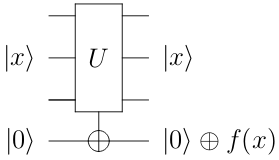

An input $\left \vert x \right >$ and ancilla qubits initialized to $\left \vert 0 \right >$ (in this case only one qubit) are provided to the oracle, which provides two outputs: $\left \vert x \right >$ and an eventual variation of $\left \vert 0 \right >$, according to the value of the Boolean function of the oracle in $\left \vert x \right >$. Since $0 \oplus f(x) = f(x)$, the output result of the Boolean function for the input $\left \vert x \right >$ is mapped onto the ancilla qubit.

A general methodology for the design of Boolean oracles is the following:
* Derive the Boolean function $f(x)$.
* Write the quantum circuit $U_{f(x)}$ associated to the Boolean function and map it onto an ancilla qubit with a CX or a CCX (it depends on the complexity on the circuit).
* The application of the quantum circuit to the input does not usually ensure that input is kept, *i.e.* $U_{f(x)} \left \vert x \right > \neq \left \vert x \right >$. For this reason, the "mirror circuit" $U_{f(x)}^{\dagger}$ should be applied to the qubits associated to input, so that $U_{f(x)}^\dagger U_{f(x)} \left \vert x \right > = \left \vert x \right >$.

The quantum circuit of a generic Boolean oracle is reported in the following.
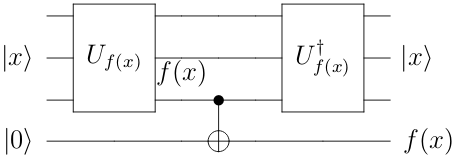

**Pay attention:**
* The operation for passing $f(x)$ to the ancilla is not always a CX (it could be a CCX, it depends on the specific function) and the CX is not always between the lowest qubit of the data quantum register and the ancilla (as in this case).
* If the same input is applied to more intermediate terms of the Boolean function (*e.g.* $x_2$ in $x_2 x_1 + \overline{x}_2 x_0$), uncomputation must be done immediately.

At this point, it is convenient to present the simplest Boolean oracles:

* NOT $\overline{x}$ is implemented by a X gate, so X gate followed by a CX and another X for uncomputation on data qubit is sufficient for designing a NOT oracle.
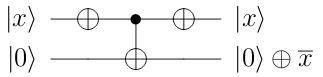
* AND $xy$ is implemented by a CCX gate, where the two inputs are the control bits of the gate and an ancilla bit initialized to 0 is employed as target. CCX gate is sufficient for implementing a AND oracle.
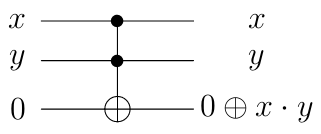
* OR $x + y$ is implemented by a CCX gate following the negation (X gate) of both inputs. Since the ancilla qubit must be equal to 1 and it is initialized to 0, it must be negated too. The Boolean function changing the ancilla is $1 \oplus \overline{x} \cdot \overline{y} = 1 \oplus \overline{x+y} = \overline{\overline{x+y}} = x+y$, according to De Morgan's laws. In order to uncompute the operations on the two inputs, two additional X gates must be applied on data qubits.
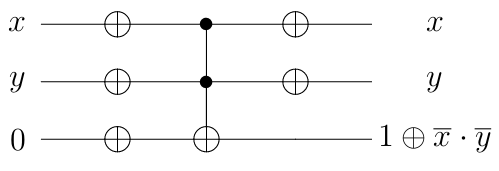
* XOR $x \oplus y$ can be simply implemented by a CX gate, where one of the two inputs is provided on the output while the other is output is equal to the XOR operation between the inputs. In the contest of Boolean oracle design, two solutions are proposed in the following: the first one is based on the methodology exploited for all the proposed implementations (Boolean circuit on inputs, copy the result on the ancilla, uncompute the Boolean function on inputs), while the other presents two CX, characterized by the same target (the ancilla) and different control qubits (each input). This solution presents a lower number of quantum gates than the other.
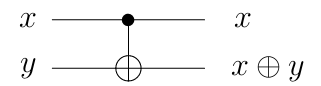
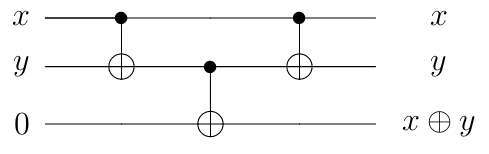
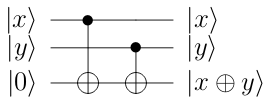

Testing of Boolean functions with quantum circuits will be provided in the following. Hadamard gates are applied at the beginning of each circuit in order to evaluate all the possible results at the same time.

In [2]:
'''NOT oracle (one qubit)'''

inputs = QuantumRegister(1,'inp')
ancilla = QuantumRegister(1,'ancilla')
propagatedInputs = ClassicalRegister(1,'propInp')
output = ClassicalRegister(1, 'out')

qcNOT = QuantumCircuit(inputs, ancilla, propagatedInputs, output)
qcNOT.h(inputs)
qcNOT.x(inputs)
qcNOT.cx(inputs, ancilla)
qcNOT.x(inputs)
qcNOT.measure([inputs[0], ancilla[0]], [propagatedInputs[0], output[0]])

'''Two-qubit oracles'''

inputs = QuantumRegister(2,'inp')
ancilla = QuantumRegister(1,'ancilla')
propagatedInputs = ClassicalRegister(2,'propInp')
output = ClassicalRegister(1, 'out')

qcAND = QuantumCircuit(inputs, ancilla, propagatedInputs, output)
qcAND.h(inputs)
qcAND.ccx(inputs[0], inputs[1], ancilla)
qcAND.measure([inputs[0], inputs[1], ancilla[0]], [propagatedInputs[0], propagatedInputs[1], output[0]])

qcOR = QuantumCircuit(inputs, ancilla, propagatedInputs, output)
qcOR.h(inputs)
qcOR.x(inputs)
qcOR.x(ancilla)
qcOR.ccx(inputs[0], inputs[1], ancilla)
qcOR.x(inputs)
qcOR.measure([inputs[0], inputs[1], ancilla[0]], [propagatedInputs[0], propagatedInputs[1], output[0]])

qcXOR1 = QuantumCircuit(inputs, ancilla, propagatedInputs, output)
qcXOR1.h(inputs)
qcXOR1.cx(inputs[0], inputs[1])
qcXOR1.cx(inputs[1], ancilla)
qcXOR1.cx(inputs[0], inputs[1])
qcXOR1.measure([inputs[0], inputs[1], ancilla[0]], [propagatedInputs[0], propagatedInputs[1], output[0]])

qcXOR2 = QuantumCircuit(inputs, ancilla, propagatedInputs, output)
qcXOR2.h(inputs)
qcXOR2.cx(inputs[0], ancilla)
qcXOR2.cx(inputs[1], ancilla)
qcXOR2.measure([inputs[0], inputs[1], ancilla[0]], [propagatedInputs[0], propagatedInputs[1], output[0]])

backend = Aer.get_backend('qasm_simulator')
result = execute(qcNOT, backend, shots=1024).result()
print("NOT results: %s" % result.get_counts() )

backend = Aer.get_backend('qasm_simulator')
result = execute(qcAND, backend, shots=1024).result()
print("AND results: %s" % result.get_counts() )

backend = Aer.get_backend('qasm_simulator')
result = execute(qcOR, backend, shots=1024).result()
print("OR results: %s" % result.get_counts() )

backend = Aer.get_backend('qasm_simulator')
result = execute(qcXOR1, backend, shots=1024).result()
print("XOR results: %s" % result.get_counts() )

backend = Aer.get_backend('qasm_simulator')
result = execute(qcXOR2, backend, shots=1024).result()
print("XOR results: %s" % result.get_counts() )

NOT results: {'0 1': 510, '1 0': 514}
AND results: {'1 11': 262, '0 00': 261, '0 01': 231, '0 10': 270}
OR results: {'1 10': 252, '1 11': 227, '1 01': 277, '0 00': 268}
XOR results: {'1 10': 246, '1 01': 298, '0 00': 240, '0 11': 240}
XOR results: {'1 10': 263, '1 01': 292, '0 00': 228, '0 11': 241}


In order to understand how to combine Boolean functions, a slightly more complex example is reported in the following: it is the oracle for $f(x) = x_2 x_1 + x_0$, where the AND operation must be computed before the OR.
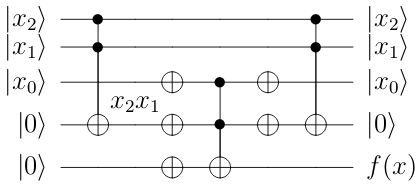
It must be observed that two ancilla bits are required, one per each operation. The first CCX gate is required for obtaining $x_2 x_1$, then the X gates on the lowest bits and the following CCX permit to have the OR operation between $x_2 x_1$ and $x_0$. The specular circuit is required for restoring the three inputs. While the ancilla exploited for OR stores the result of the Boolean function $f(x)$, the AND one is useless, so it does not have to be measured.
The test of the designed oracle is in the following cells.

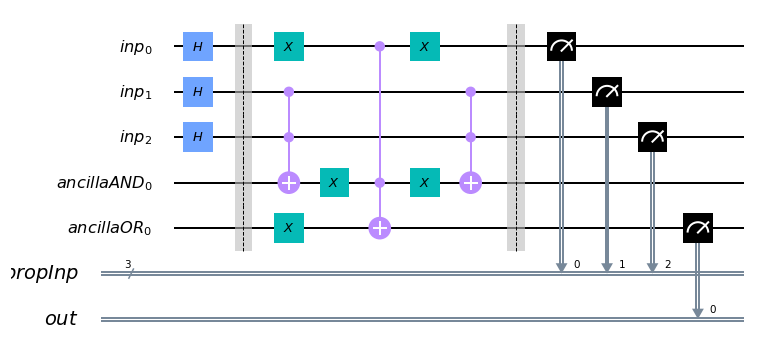

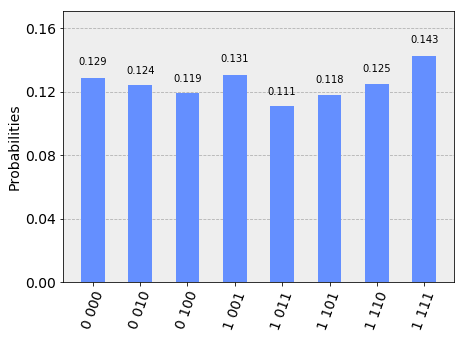

In [3]:
inputs = QuantumRegister(3,'inp')
ancillaAND = QuantumRegister(1,'ancillaAND')
ancillaOR = QuantumRegister(1,'ancillaOR')
propagatedInputs = ClassicalRegister(3,'propInp')
output = ClassicalRegister(1, 'out')

qc = QuantumCircuit(inputs, ancillaAND, ancillaOR, propagatedInputs, output)
qc.h(inputs)
qc.barrier()
qc.ccx(inputs[2], inputs[1], ancillaAND)
qc.x([inputs[0], ancillaAND[0], ancillaOR[0]])
qc.ccx(inputs[0], ancillaAND, ancillaOR)
qc.x([inputs[0], ancillaAND[0]])
qc.ccx(inputs[2], inputs[1], ancillaAND)
qc.barrier()
qc.measure([inputs[0], inputs[1], inputs[2], ancillaOR[0]], [propagatedInputs[0], propagatedInputs[1], propagatedInputs[2], output[0]])
display(qc.draw(output='mpl'))

backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=1024).result()
visualization.plot_histogram(result.get_counts() )

### Ex. 1: Single-target Boolean oracles ###

Design the Boolean oracles (**each one separately**) with $f(x) = 1$ for $x = \left \vert 01 \right >$, $x = \left \vert 111 \right >$ and $x = \left \vert 1010 \right >$

**Solution** The Boolean functions to be implemented are

$$f_{01} = \overline{x}_1 \cdot x_0$$
$$f_{111} = x_2 \cdot x_1 \cdot x_0$$
$$f_{1010} = x_3 \cdot \overline{x}_2 \cdot x_1 \cdot \overline{x}_0$$

$f_{01}$ can be easily implemented by a CCX gate, according to the following quantum circuit

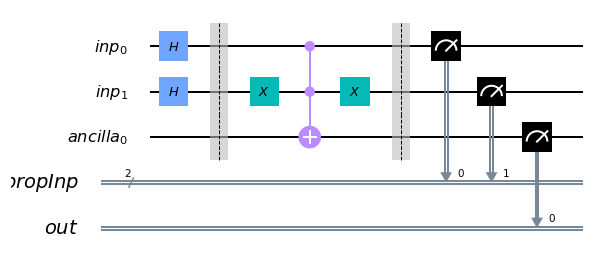

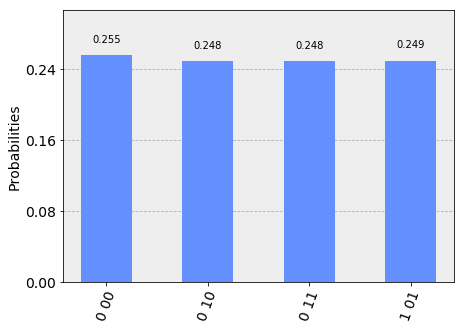

In [4]:
inputs = QuantumRegister(2,'inp')
ancilla = QuantumRegister(1,'ancilla')
propagatedInputs = ClassicalRegister(2,'propInp')
output = ClassicalRegister(1, 'out')

qc_oracle_01 = QuantumCircuit(inputs, ancilla, propagatedInputs, output)
qc_oracle_01.h(inputs)
qc_oracle_01.barrier() # inserted for better visualization of the oracle
qc_oracle_01.x(inputs[1])
qc_oracle_01.ccx(inputs[0], inputs[1], ancilla)
qc_oracle_01.x(inputs[1])
qc_oracle_01.barrier() # inserted for better visualization of the oracle
qc_oracle_01.measure([inputs[0], inputs[1], ancilla[0]], [propagatedInputs[0], propagatedInputs[1], output[0]])

display(qc_oracle_01.draw(output='mpl'))

backend = Aer.get_backend('qasm_simulator')
result = execute(qc_oracle_01, backend, shots=1024).result()
visualization.plot_histogram(result.get_counts())

The other two oracles need CCCX and CCCCX gates respectively, two gates that are not native in Qiskit. However, they can be built by exploiting additional ancilla qubits: in the CCCX case, we need one additional ancilla, in the other we need two additional qubits. A possible approach for the implementation of the $\text{C}^n \text{X}$ with $n$ control qubits is based on dividing the problem into simpler CCX gates to be then combined together. The proposed approach presents $n-2$ ancilla qubits initialized to 0 and an example - the $\text{C}^5 \text{X}$ - is reported in the following.

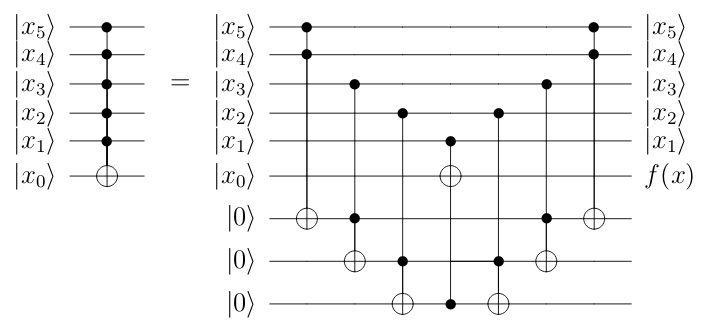

The circuits for the implementation of the oracles to be designed are the following.

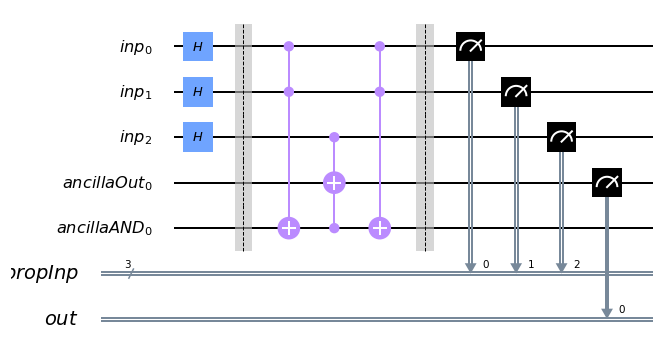

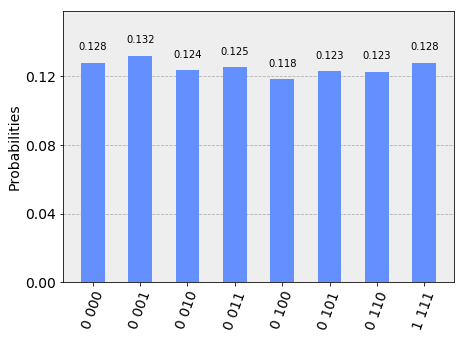

In [5]:
'''CCCX-based oracle'''

inputs = QuantumRegister(3,'inp')
ancilla_out = QuantumRegister(1,'ancillaOut')
ancilla_AND = QuantumRegister(1,'ancillaAND')
propagatedInputs = ClassicalRegister(3,'propInp')
output = ClassicalRegister(1, 'out')

qc_oracle_111 = QuantumCircuit(inputs, ancilla_out, ancilla_AND, propagatedInputs, output)
qc_oracle_111.h(inputs)
qc_oracle_111.barrier() # inserted for better visualization of the oracle
qc_oracle_111.ccx(inputs[0], inputs[1], ancilla_AND)
qc_oracle_111.ccx(inputs[2], ancilla_AND, ancilla_out)
qc_oracle_111.ccx(inputs[0], inputs[1], ancilla_AND)
qc_oracle_111.barrier() # inserted for better visualization of the oracle
qc_oracle_111.measure([inputs[0], inputs[1], inputs[2], ancilla_out[0]], [propagatedInputs[0], propagatedInputs[1], propagatedInputs[2], output[0]])

display(qc_oracle_111.draw(output='mpl'))

backend = Aer.get_backend('qasm_simulator')
result = execute(qc_oracle_111, backend, shots=4096).result()
visualization.plot_histogram(result.get_counts())

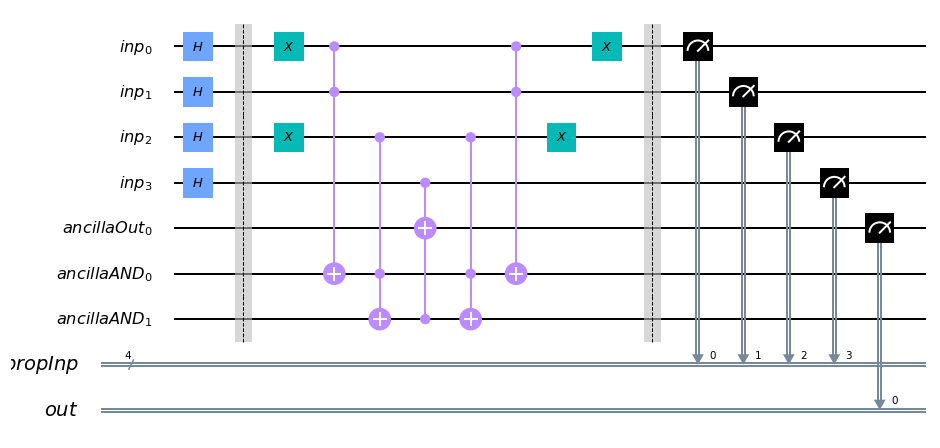

{'0 1000': 529, '0 0101': 523, '0 1100': 501, '0 1101': 536, '0 1011': 525, '0 1110': 501, '0 1111': 514, '1 1010': 537, '0 0110': 526, '0 0011': 513, '0 0001': 483, '0 1001': 501, '0 0111': 525, '0 0000': 486, '0 0010': 499, '0 0100': 493}


In [6]:
'''CCCCX-based oracle'''

inputs = QuantumRegister(4,'inp')
ancilla_out = QuantumRegister(1,'ancillaOut')
ancilla_AND = QuantumRegister(2,'ancillaAND')
propagatedInputs = ClassicalRegister(4,'propInp')
output = ClassicalRegister(1, 'out')

qc_oracle_1010 = QuantumCircuit(inputs, ancilla_out, ancilla_AND, propagatedInputs, output)
qc_oracle_1010.h(inputs)
qc_oracle_1010.barrier() # inserted for better visualization of the oracle
qc_oracle_1010.x([inputs[0], inputs[2]])
qc_oracle_1010.ccx(inputs[0], inputs[1], ancilla_AND[0])
qc_oracle_1010.ccx(inputs[2], ancilla_AND[0], ancilla_AND[1])
qc_oracle_1010.ccx(inputs[3], ancilla_AND[1], ancilla_out)
qc_oracle_1010.ccx(inputs[2], ancilla_AND[0], ancilla_AND[1])
qc_oracle_1010.ccx(inputs[0], inputs[1], ancilla_AND[0])
qc_oracle_1010.x([inputs[0], inputs[2]])
qc_oracle_1010.barrier() # inserted for better visualization of the oracle
qc_oracle_1010.measure(list(inputs) + list(ancilla_out), list(propagatedInputs) + list(output)) # more compact form

display(qc_oracle_1010.draw(output='mpl'))

backend = Aer.get_backend('qasm_simulator')
result = execute(qc_oracle_1010, backend, shots=8192).result()
print(result.get_counts())

### Ex. 2: Two possible 1s ###

Design the reversible circuit of a logical oracle with $f(x) = 1$ when $x$ is equal to $\left | 011 \right >$ or $\left | 101 \right >$.

**Solution** The boolean function to be implemented is $f(x) = \overline{x}_2 x_1 x_0 + x_2 \overline{x}_1 x_0 = (x_2 \oplus x_1) \cdot x_0$

OPENQASM 2.0;
include "qelib1.inc";
qreg xIn[3];
qreg ancilla[1];
qreg ancillaXOR[1];
creg propInp[3];
creg out[1];
h xIn[0];
h xIn[1];
h xIn[2];
barrier xIn[0],xIn[1],xIn[2],ancilla[0],ancillaXOR[0];
cx xIn[2],xIn[1];
cx xIn[1],ancillaXOR[0];
ccx xIn[0],ancillaXOR[0],ancilla[0];
cx xIn[1],ancillaXOR[0];
cx xIn[2],xIn[1];
barrier xIn[0],xIn[1],xIn[2],ancilla[0],ancillaXOR[0];
measure xIn[0] -> propInp[0];
measure xIn[1] -> propInp[1];
measure xIn[2] -> propInp[2];
measure ancilla[0] -> out[0];



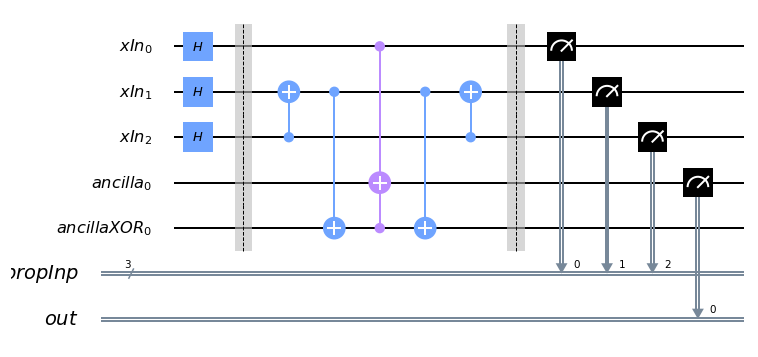

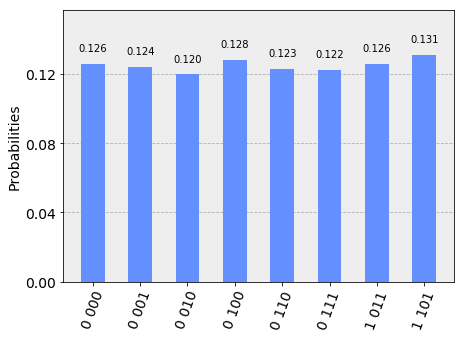

In [7]:
xInputs = QuantumRegister(3, 'xIn')
ancillaQubit = QuantumRegister(1, 'ancilla')
ancilla_XOR = QuantumRegister(1, 'ancillaXOR')
propagatedInputs = ClassicalRegister(3,'propInp')
output = ClassicalRegister(1, 'out')

qc_oracle_011_101 = QuantumCircuit(xInputs, ancillaQubit, ancilla_XOR, propagatedInputs, output)

qc_oracle_011_101.h(xInputs)
qc_oracle_011_101.barrier()
qc_oracle_011_101.cx(xInputs[2], xInputs[1])
qc_oracle_011_101.cx(xInputs[1], ancilla_XOR)
qc_oracle_011_101.ccx(xInputs[0], ancilla_XOR, ancillaQubit)
qc_oracle_011_101.cx(xInputs[1], ancilla_XOR)
qc_oracle_011_101.cx(xInputs[2], xInputs[1])
qc_oracle_011_101.barrier()
qc_oracle_011_101.measure( [xInputs[0], xInputs[1], xInputs[2], ancillaQubit[0]], [propagatedInputs[0], propagatedInputs[1], propagatedInputs[2], output[0]] )

print(qc_oracle_011_101.qasm()) # in this case the circuit description in Quantum Assembly is reported
display(qc_oracle_011_101.draw(output='mpl'))

backend = Aer.get_backend('qasm_simulator')
result = execute(qc_oracle_011_101, backend, shots=8192).result()
visualization.plot_histogram(result.get_counts())

### Ex.3: Oracle for triangle coloring ###

Let us assume that the vertices of a triangle are labelled with a number on two bits. Design the quantum oracle ensuring that the three labels are all different.

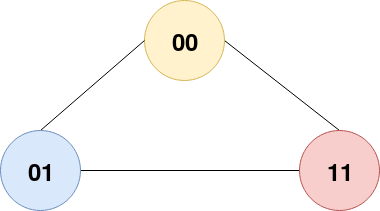

**Solution** If the three labels are $(a_0, a_1), (b_0, b_1), (c_0, c_1)$, the Boolean function to be implemented is
$$f(x) = [(a_0 \oplus b_0) + (a_1 \oplus b_1)] \cdot [(c_0 \oplus b_0) + (c_1 \oplus b_1)] \cdot [(a_0 \oplus c_0) + (a_1 \oplus c_1)]$$. This function is equal to 1 if and only if the three labels are all different (*e.g.* 00,10,11). XOR operations must be done before the products (AND). Differently from the previous notation approach, this quantum circuit has been written in Quantum Assembly (QASM) language. The content of the file can be read with the next cell, then the following one contains the code for loading a QASM-described circuit into Qiskit. In the execution cell only the inputs providing an oracle equal to 1 are printed; it is possible to observe that labels are all different.

OPENQASM 2.0;

include "qelib1.inc";

qreg xIn[6];

qreg ancillaXOR[6];

qreg ancillaOR[3];

qreg ancillaAND[1];

qreg flagIn[1];

creg xOut[6];

creg flagOut[1];



h xIn;



x ancillaOR;



cx xIn[0], xIn[2];

cx xIn[2], ancillaXOR[0];

cx xIn[0], xIn[2];



cx xIn[1], xIn[3];

cx xIn[3], ancillaXOR[1];

cx xIn[1], xIn[3];



cx xIn[0], xIn[4];

cx xIn[4], ancillaXOR[2];

cx xIn[0], xIn[4];



cx xIn[1], xIn[5];

cx xIn[5], ancillaXOR[3];

cx xIn[1], xIn[5];



cx xIn[2], xIn[4];

cx xIn[4], ancillaXOR[4];

cx xIn[2], xIn[4];



cx xIn[3], xIn[5];

cx xIn[5], ancillaXOR[5];

cx xIn[3], xIn[5];



x ancillaXOR;



ccx ancillaXOR[0], ancillaXOR[1], ancillaOR[0];

ccx ancillaXOR[2], ancillaXOR[3], ancillaOR[1];

ccx ancillaXOR[4], ancillaXOR[5], ancillaOR[2];



ccx ancillaOR[0], ancillaOR[1], ancillaAND[0];



ccx ancillaOR[2], ancillaAND[0], flagIn[0];



ccx ancillaOR[0], ancillaOR[1], ancillaAND[0];



ccx ancillaXOR[4], ancillaXOR[5], ancillaOR[2];

ccx ancillaXOR[2], ancillaXOR[3]

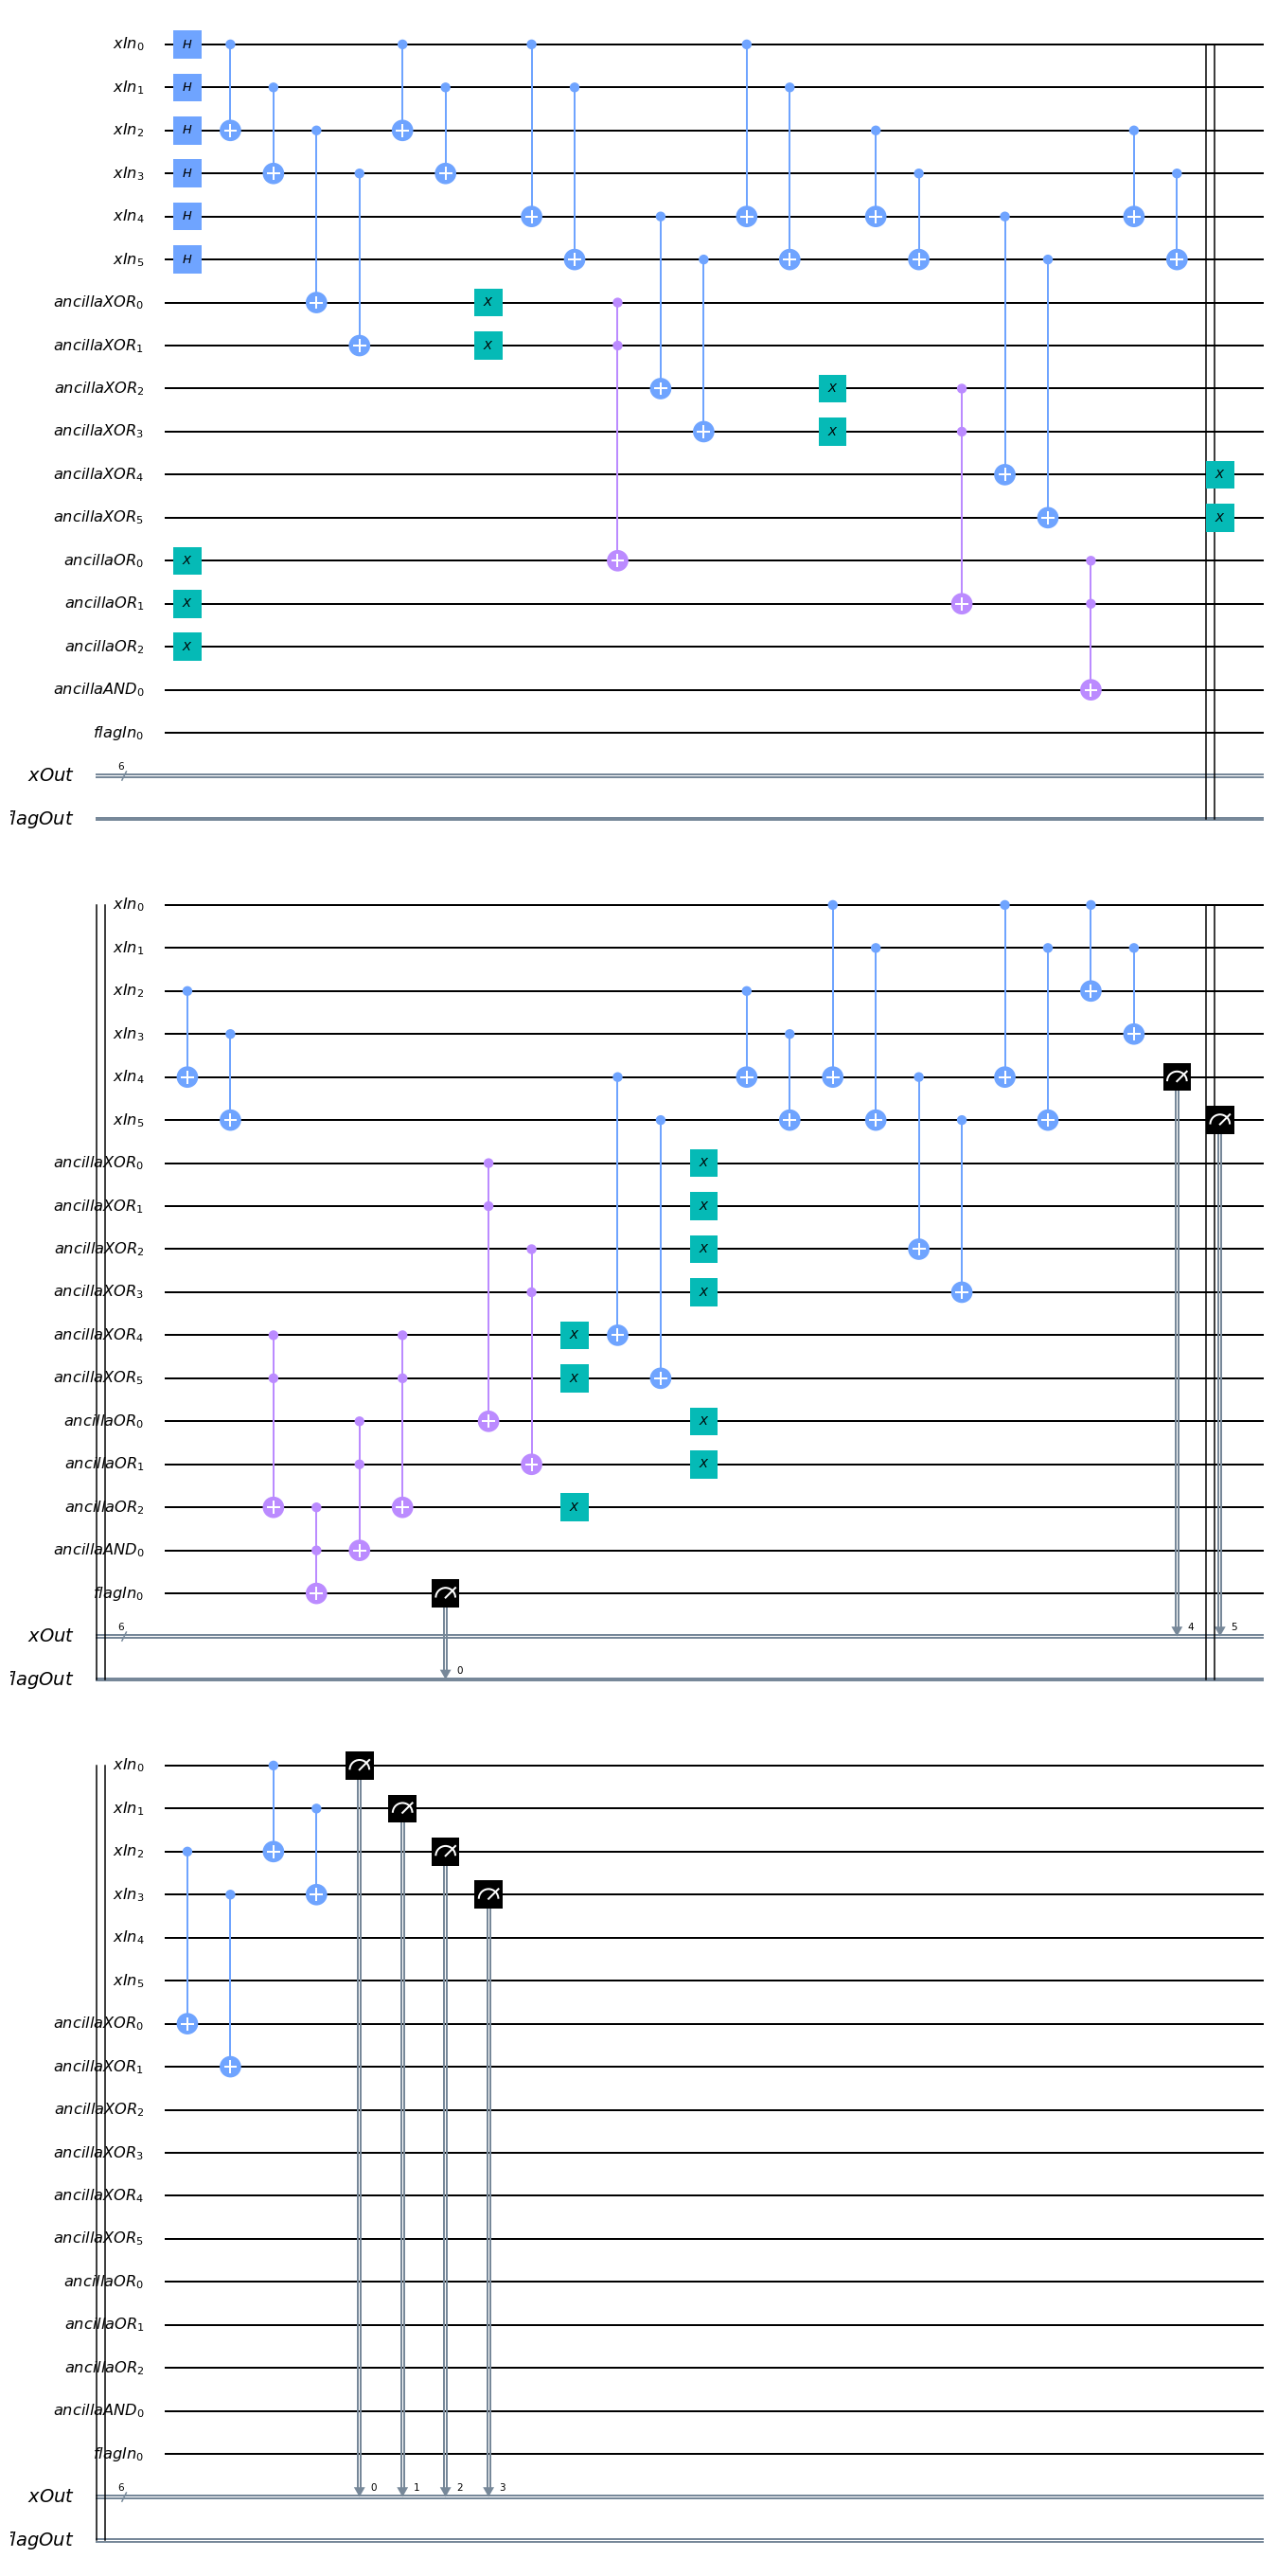

1 010011
1 110010
1 000111
1 011110
1 100011
1 010010
1 111001
1 101100
1 001011
1 110001
1 110100
1 011100
1 110110
1 011011
1 101101
1 001110
1 100111
1 001001
1 000110
1 100100
1 011000
1 100001
1 111000
1 001101


In [8]:
with open("oracle_triangle.qasm",'r') as qasmFile:
    for line in qasmFile:
        print(line)

qc = QuantumCircuit.from_qasm_file('oracle_triangle.qasm')

display(qc.draw(output = 'mpl'))

backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=8192).result()
counts = result.get_counts()

for key in counts.keys():
    if key[0] == '1': # the first character refers to the output provided by the oracle
        print(key)

### Ex. 4: Square values of integer numbers ###

Design the oracle for computing the square values of the integer numbers representable on three bits, without designing any reversible multiplier.

**Solution** The square value of a number representable on $n$ bits can be written on $2n$ bits, so in this case 6 Boolean oracles must be designed in parallel. The complete truth table is reported in the following. The Boolean functions are not reported. Writing them is an useful exercise; looking at each output column, it is possible to ascertain that it is much simpler than what expected.

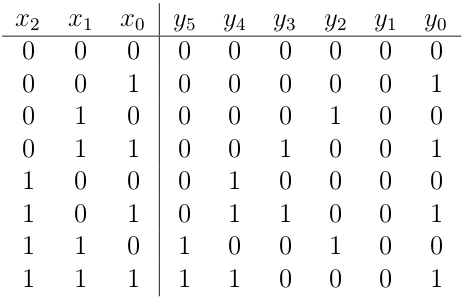

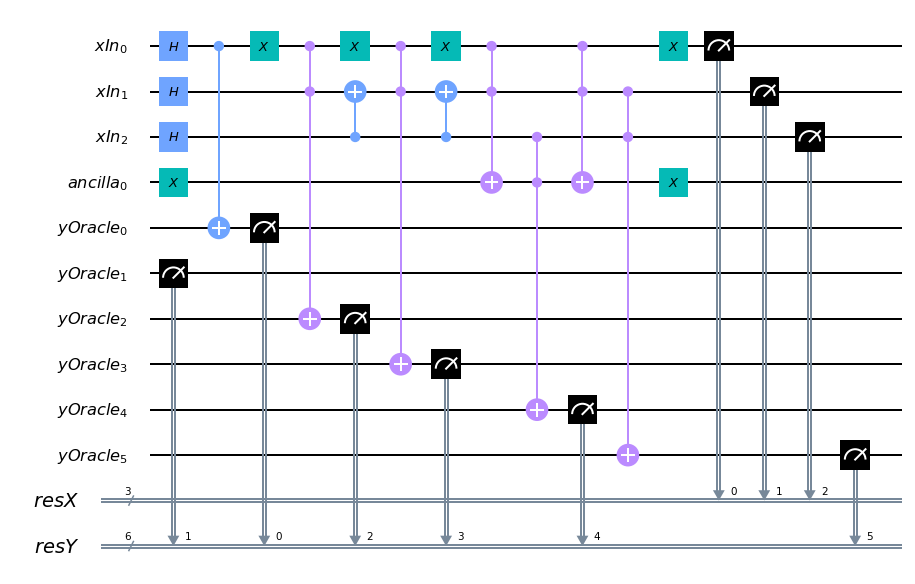

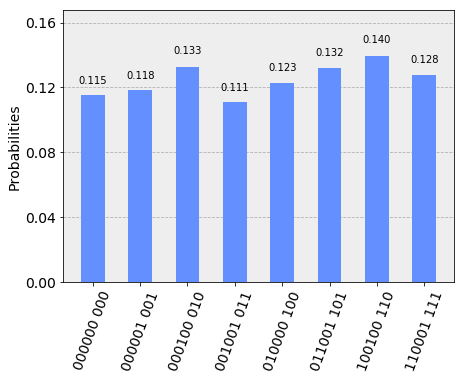

In [9]:
xQubits = QuantumRegister(3, 'xIn')
ancillaQubit = QuantumRegister(1, 'ancilla')
yQubits = QuantumRegister(6, 'yOracle')
resultsX = ClassicalRegister(3, 'resX')
resultsY = ClassicalRegister(6, 'resY')

'''y0'''
qc = QuantumCircuit(xQubits, ancillaQubit, yQubits, resultsX, resultsY)
qc.h(xQubits)
qc.cx(xQubits[0], yQubits[0])

'''y2'''
qc.x(xQubits[0])
qc.ccx(xQubits[0], xQubits[1], yQubits[2])
qc.x(xQubits[0])

'''y3'''
qc.cx(xQubits[2], xQubits[1])
qc.ccx(xQubits[0], xQubits[1], yQubits[3])
qc.cx(xQubits[2], xQubits[1])

'''y4'''
qc.x(xQubits[0])
qc.x(ancillaQubit)
qc.ccx(xQubits[0], xQubits[1], ancillaQubit)
qc.ccx(xQubits[2], ancillaQubit, yQubits[4])
qc.ccx(xQubits[0], xQubits[1], ancillaQubit)
qc.x(ancillaQubit)
qc.x(xQubits[0])

'''y5'''
qc.ccx(xQubits[2], xQubits[1], yQubits[5])

qc.measure(xQubits, resultsX)
qc.measure(yQubits, resultsY)

display(qc.draw(output='mpl'))

backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend).result()
visualization.plot_histogram(result.get_counts())

## Phase oracle ##

While Boolean oracles can be also employed with classical bits, phase oracles are exclusive of quantum bits. They are employed in quantum algorithms as the Grover's search or amplitude amplification for labeling the solution of the problem. As written in the introduction, given an input $\left \vert x \right >$, phase oracle provides a unitary evolution of type $(-1)^{f(x)} \left \vert x \right >$, where $f(x)$ can be 0 or 1 according to the input $\left \vert x \right >$. According to this definition, it is possible to understand that phase oracles can be built from Boolean ones and a methodology for this design is reported in the following.

Let us imagine that we have a certain input and a Boolean oracle $U$ associated to a Boolean function $f(x)$. According to the provided input x, f(x) can be 0 or 1 and it is passed with a XOR operation (it could be simply implemented by cx or ccx) to the ancilla bit: it means that the ancilla bit is $\left \vert 0 \right >$ if $f(x)=0$ and $\left \vert 1 \right >$ when $f(x)=1$. This approach can be extended to the phase oracles, assuming that the target of our search $\left \vert x \right >$ has a corresponding $f(x)=1$. We compute the Boolean oracle, so we have $\left \vert 0 \right >$ or $\left \vert 1 \right >$ on the ancilla according to the input, then we apply a Z gate on the ancilla, so that it is $\left \vert 0 \right >$ or $-1\left \vert 1 \right >$, depending on $f(x)$ for sure. At this point we compute the Boolean oracle again, in order to ensure that on the ancilla there will be $(-1)^{f(x)} \left \vert 0 \right >$, i.e. $\left \vert 0 \right >$ for $f(x)=0$ and $- \left \vert 0 \right >$ for $f(x)=1$. The presence of the basis state $\left \vert 0 \right >$ on the ancilla is ensured by the fact that for $f(x)=0$ no operations are executed on the ancilla, while for $f(x)=1$ two negations (with a consequent identity) are executed. Since ancilla and data qubits are not entangled, we can finally "pass" the scalar value from $\left \vert 0 \right >$ to $\left \vert x \right >$, which will finally be $\left \vert x \right >$ for $f(x)=0$ and $- \left \vert x \right >$ for $f(x)=1$.

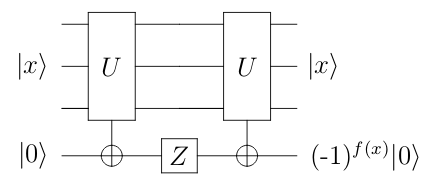

It is important to precise that this methodology is not the best one in terms of hardware resources allocation (number of qubits). Even though examples of optimized versions are reported in the examples, the simplest optimization can be already presented. It is reminded that each Boolean oracle is made of two unitary evolutions $U_{f(x)}$ and $U^{\dagger} _{f(x)}$, separated by a CX (or CCX) for having the $f(x)$ outcome on the ancilla. However, the $U^{\dagger} _{f(x)}$ of the first Boolean oracle employed in the phase oracle and $U_{f(x)}$ of the second Boolean oracle compensate each other, *i.e.* the unitary evolution related to their sequence is an identity. For this reason, the phase oracle can be simplified in the following way, ensuring that at the end of the quantum circuit there is $\left \vert x \right >$ on "data" qubits.

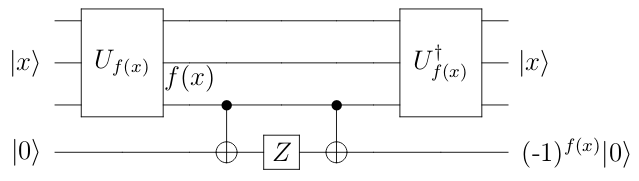

### A particular case: single-target phase oracle ###

Single target phase oracles change the phase of the probability ampltiude of one basis state $\left \vert x_{N-1} x_{N-2} \cdots x_1 x_0 \right >$. In this case, phase oracles can be built by using a $\text{C}^{n} Z$ gate, where $n = N-1$. In the Boolean oracle section, the $\text{C}^{n} X$ gate was introduced; the $\text{C}^{n} Z$ and $\text{C}^{n} X$ gates are related by the following equation

$$ \text{C}^{n} Z = H \cdot \text{C}^{n} X \cdot H $$,

where the Hadamard gates must be applied on the target qubit of the $\text{C}^{n} X$ gate. It must be observed that the standard $\text{C}^{n} Z$ gate changes the phase of $\left \vert 1 1 \cdots 1 1 \right >$. If the target presents some 0, X gates must be applied on the corresponding qubit before and after the $\text{C}^{n} Z$ gate. The $\text{C}^{n} Z$ gate-based phase oracle for $\left \vert 101101 \right >$ is reported in the following.

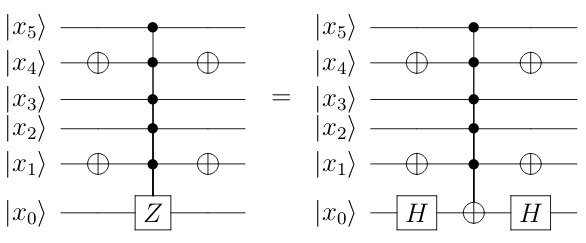

### Ex.1: Two-qubit single-target phase oracle ###

Design the phase oracle for input $\left \vert 10 \right >$

**Solution** The Boolean oracle is based on the function $x_1 \overline{x}_0$. The methodology for the design of Boolean oracles is exactly the same of the previous section: a CCX gate, preceded and followed by X gates on $x_0$, is sufficient for implementing the Boolean oracle.

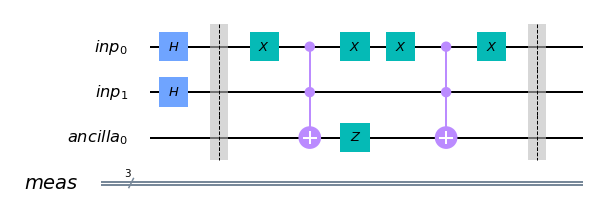

[ 0.5+0.j  0.5+0.j -0.5+0.j  0.5+0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]


In [10]:
inputs = QuantumRegister(2, 'inp')
ancilla = QuantumRegister(1, 'ancilla')
res = ClassicalRegister(3, 'meas')

oracle_phase_10 = QuantumCircuit(inputs, ancilla, res)

oracle_phase_10.h(inputs) # evaluate all inputs at the same time

oracle_phase_10.barrier()

''' BOOLEAN ORACLE'''
oracle_phase_10.x(inputs[0])
oracle_phase_10.ccx(inputs[0], inputs[1], ancilla)
oracle_phase_10.x(inputs[0])

# at this point ancilla is |1> for |10>, |0> otherwise 

oracle_phase_10.z(ancilla) # Z gate on ancilla

# at this point ancilla is -|1> for |10>, |0> otherwise 

''' BOOLEAN ORACLE UNCOMPUTATION'''
oracle_phase_10.x(inputs[0])
oracle_phase_10.ccx(inputs[0], inputs[1], ancilla)
oracle_phase_10.x(inputs[0])

# at this point ancilla is -|0> for |10>, |0> otherwise 

oracle_phase_10.barrier()

display(oracle_phase_10.draw(output='mpl'))

backend = Aer.get_backend('statevector_simulator')
result = execute(oracle_phase_10, backend).result()

print(result.get_statevector())

In the result, obtained with the "statevector_simulator" backend, the state related to "010" (the result's state vector is related to three qubits, where the ancilla is the most significant one) has opposite sign with the respect to the others.

The intermediate X gates on $x_0$ ($inp_0$ in the circuit picture) are useless, since $X^2 = I$, thus proving what previously written about the compensation of the $U^{\dagger} _{f(x)}$ of the first Boolean oracle and $U_{f(x)}$ of the second one.

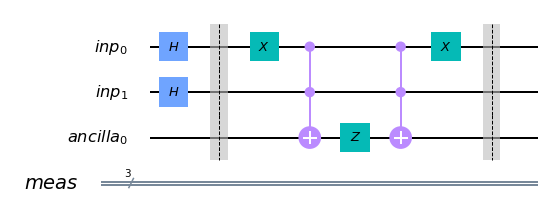

[ 0.5+0.j  0.5+0.j -0.5+0.j  0.5+0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]


In [11]:
inputs = QuantumRegister(2, 'inp')
ancilla = QuantumRegister(1, 'ancilla')
res = ClassicalRegister(3, 'meas')

oracle_phase_10 = QuantumCircuit(inputs, ancilla, res)

oracle_phase_10.h(inputs) # evaluate all inputs at the same time

oracle_phase_10.barrier()

''' BOOLEAN ORACLE'''
oracle_phase_10.x(inputs[0])
oracle_phase_10.ccx(inputs[0], inputs[1], ancilla)

# at this point ancilla is |1> for |10>, |0> otherwise 

oracle_phase_10.z(ancilla) # Z gate on ancilla

# at this point ancilla is -|1> for |10>, |0> otherwise 

''' BOOLEAN ORACLE UNCOMPUTATION'''
oracle_phase_10.ccx(inputs[0], inputs[1], ancilla)
oracle_phase_10.x(inputs[0])

# at this point ancilla is -|0> for |10>, |0> otherwise 

oracle_phase_10.barrier()

display(oracle_phase_10.draw(output='mpl'))

backend = Aer.get_backend('statevector_simulator')
result = execute(oracle_phase_10, backend).result()

print(result.get_statevector())

For this particular case, it is not necessary to use an ancilla qubit for the design of the phase oracle. A CZ gate, preceded and followed by X gates on $x_0$, is sufficient for implementing the phase oracle.

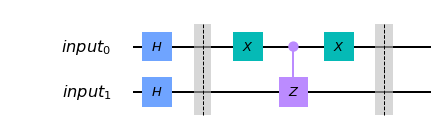

[ 0.5+0.j  0.5+0.j -0.5+0.j  0.5+0.j]


In [12]:
inputs = QuantumRegister(2, 'input')

oracle_phase_10 = QuantumCircuit(inputs)

oracle_phase_10.h(inputs) # evaluate all inputs at the same time
oracle_phase_10.barrier()

'''PHASE ORACLE'''
oracle_phase_10.x(inputs[0])
oracle_phase_10.cz(inputs[0], inputs[1])
oracle_phase_10.x(inputs[0])

oracle_phase_10.barrier()

display(oracle_phase_10.draw(output='mpl'))

backend = Aer.get_backend('statevector_simulator')
result = execute(oracle_phase_10, backend).result()

print(result.get_statevector())

### Ex.2: Three-qubit single-target phase oracle ###

Design the phase oracle for input $\left \vert 011 \right >$.

**Solution** Two possible approaches can be followed for designing this oracle:
* exploiting the Boolean oracle for $f(x) = \overline{x}_2 x_1 x_0$ (*i.e.* a $\text{C}^3 \text{X}$ gate);
* exploiting the CCZ gate, preceded and followed by X gates on $x_2$, which is not native in Qiskit, but buildable from the CCX.


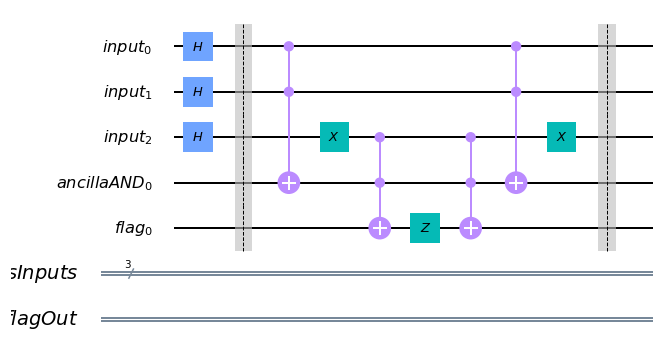

[ 0.35355339+0.j  0.35355339+0.j  0.35355339+0.j -0.35355339+0.j
  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]


In [13]:
inputs = QuantumRegister(3, 'input')
ancillaAND = QuantumRegister(1, 'ancillaAND')
flag = QuantumRegister(1, 'flag')
resInputs = ClassicalRegister(3, 'resInputs')
resFlag = ClassicalRegister(1, 'flagOut')

oracle_phase_011 = QuantumCircuit(inputs, ancillaAND, flag, resInputs, resFlag)

oracle_phase_011.h(inputs)

oracle_phase_011.barrier()
oracle_phase_011.x(inputs[2])
oracle_phase_011.ccx(inputs[0], inputs[1], ancillaAND[0])
oracle_phase_011.ccx(inputs[2], ancillaAND[0], flag)
oracle_phase_011.z(flag)
oracle_phase_011.ccx(inputs[2], ancillaAND[0], flag)
oracle_phase_011.ccx(inputs[0], inputs[1], ancillaAND[0])
oracle_phase_011.x(inputs[2])
oracle_phase_011.barrier()

display(oracle_phase_011.draw(output='mpl'))

backend = Aer.get_backend('statevector_simulator')
result = execute(oracle_phase_011, backend).result()

print(result.get_statevector())

The CCZ gate permits to avoid ancilla qubits. Even though it is not native in Qiskit, it can be built from the CCX, according to the equivalence presented in the introduction.

In [ ]:
inputs = QuantumRegister(3, 'input')
ancillaAND = QuantumRegister(1, 'ancillaAND')
flag = QuantumRegister(1, 'flag')
resInputs = ClassicalRegister(3, 'resInputs')
resFlag = ClassicalRegister(1, 'flagOut')

oracle_phase_011 = QuantumCircuit(inputs, ancillaAND, flag, resInputs, resFlag)

oracle_phase_011.h(inputs)

oracle_phase_011.barrier()
oracle_phase_011.x(inputs[2])
oracle_phase_011.h(inputs[0])
oracle_phase_011.ccx(inputs[2], inputs[1], inputs[0])
oracle_phase_011.h(inputs[0])
oracle_phase_011.x(inputs[2])
oracle_phase_011.barrier()

display(oracle_phase_011.draw(output='mpl'))

backend = Aer.get_backend('statevector_simulator')
result = execute(oracle_phase_011, backend).result()

print(result.get_statevector())

### Ex.3: Generic four-qubit phase oracle ###

Design the quantum circuit for the phase oracle of an input $\left \vert x_3 x_2 x_1 x_0 \right >$ to be provided as input string.

**Solution** In order to generalize the circuit, a method is written for the implementation of the phase oracle based on $X$ and $\text{C}^3 Z$ gates. The method returns the instruction associated to the designed quantum circuit. This means that the circuit can be employed as gate of other quantum circuits. It is similar to the *component* construct in classical Hardware Description Languages. The design of the phase oracle based on the Boolean one, not proposed here, could be a useful exercise.

In [ ]:
def MakeOracle(target):
    
    qubitsIn = QuantumRegister(4, 'inputs')
    qubitsAncilla = QuantumRegister(1, 'ancillas')

    oracle = QuantumCircuit(qubitsIn, qubitsAncilla)

    tmp = "{0:04b}" .format(target)
    
    oracle.barrier()

    for k in range(4):
        if tmp[4-k-1] == '0': # apply X to the qubit associated to a 0
            oracle.x(qubitsIn[k])
            
    '''CCCZ gate'''
    oracle.h(qubitsIn[0])
    oracle.ccx(qubitsIn[3], qubitsIn[2], qubitsAncilla[0])
    oracle.ccx(qubitsAncilla[0], qubitsIn[1], qubitsIn[0])
    oracle.ccx(qubitsIn[3], qubitsIn[2], qubitsAncilla[0])
    oracle.h(qubitsIn[0])

    for k in range(4):
        if tmp[4-k-1] == '0': # apply X to the qubit associated to a 0
            oracle.x(qubitsIn[k])
            
    oracle.barrier()

    oracle_inst = oracle.to_instruction() # command for interpreting the quantum circuit as an instruction, i.e. a gate to be employed in other quantum circuits. 
    
    return oracle_inst

In [ ]:
oracle_component = MakeOracle(9)

ins = QuantumRegister(4, 'inp')
ancs = QuantumRegister(1, 'anc')

circuit = QuantumCircuit(ins, ancs)

circuit.h(ins)

circuit.append(oracle_component, list(ins) + list(ancs))

display(circuit.draw(output='mpl'))

backend = Aer.get_backend('statevector_simulator')
result = execute(circuit, backend).result()
sv = result.get_statevector()

''' Only the states with probability amplitude different from 0 are printed.
In order to do that, state vector is written into a dictionary which is then filtered.
'''

svDict = {}

for k in range(len(sv)):
    svDict["{0:04b}".format(k)] = sv[k]

filterDict = dict(filter(lambda elem: np.abs(elem[1]) > 0, svDict.items())) # keep only the states with non-null probability amplitudes

print(filterDict)

### Ex.4: Multi-target oracles ###

Design the quantum circuit for the logical and phase oracles associated to the Boolean function $f(x) = x_3 x_1 \bar{x}_0 + \bar{x}_2 x_0 $

**Solution** The standard procedure can be obviuosly exploited. The most difficult part could be the design of the $U_f(x)$ quantum circuit for implementing the Boolean function, whose result must be then passed to an ancilla qubit. The input qubits are the least significant ones of the labels of the dictionary storing the results.

In [ ]:
xInputs = QuantumRegister(4, 'xIn')
ancillaQubitAND = QuantumRegister(3, 'ancillaAND')
ancillaQubitOR = QuantumRegister(1, 'ancillaOR')
flagQubit = QuantumRegister(1, 'flag')

qc = QuantumCircuit(xInputs, ancillaQubitAND, ancillaQubitOR, flagQubit)

qc.h(xInputs)

'''FIRST PRODUCT'''
qc.ccx(xInputs[3], xInputs[1], ancillaQubitAND[0])
qc.x(xInputs[0])
qc.ccx(xInputs[0], ancillaQubitAND[0], ancillaQubitAND[1])
qc.x(xInputs[0])

'''SECOND PRODUCT'''
qc.x(xInputs[2])
qc.ccx(xInputs[2], xInputs[0], ancillaQubitAND[2])

'''SUM OF TWO PRODUCTS'''
qc.x([ancillaQubitAND[1], ancillaQubitAND[2], flagQubit[0]])
qc.ccx(ancillaQubitAND[1], ancillaQubitAND[2], flagQubit)

''' Z Gate on the ancilla containing the result of U_{f(x)}'''
qc.z(flagQubit)

'''Uncompute'''

qc.x([ancillaQubitAND[1], ancillaQubitAND[2], flagQubit[0]])
qc.ccx(ancillaQubitAND[1], ancillaQubitAND[2], flagQubit)
qc.ccx(ancillaQubitAND[1], ancillaQubitAND[2], flagQubit)
qc.x([ancillaQubitAND[1], ancillaQubitAND[2], flagQubit[0]])

qc.ccx(xInputs[2], xInputs[0], ancillaQubitAND[2])
qc.x(xInputs[2])

qc.x(xInputs[0])
qc.ccx(xInputs[0], ancillaQubitAND[0], ancillaQubitAND[1])
qc.x(xInputs[0])
qc.ccx(xInputs[3], xInputs[1], ancillaQubitAND[0])

display(qc.draw(output='mpl'))

backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend).result()
sv = result.get_statevector()
svDict = {}

for k in range(len(sv)):
    svDict["{0:09b}".format(k)] = sv[k]

filterDict = dict(filter(lambda elem: np.abs(elem[1]) > 0, svDict.items()))

print(filterDict)

### Ex.5: Sum $\geq 2$ phase oracle ###

Given three single-qubit inputs $ \left \vert a \right >$, $ \left \vert b \right >$, anf $ \left \vert c \right >$, design the phase oracle for labeling their combinations providing a sum greater or equal than two.

**Solution** If at least two inputs are equal to 1, the result of the addition will be $\geq 2$. The Boolean function to be designed is
$$ ab \overline{c} + a \overline{b} c + \overline{a}bc + abc = ab + (a \oplus b) c $$
In order to design the oracle, an alternative $U_{f(x)}$ will be exploited (the standard one is left as exercise): the quantum circuit for implementing a **full-adder**, which is the most employed combinational circuit in classical digital arithmetic. It is employed for adding three one-bit input numbers $a$, $b$ and $c$ with weight $2^k$ and two outputs: $$s = a \oplus b \oplus c $$ having the same weight of the inputs and $$c_\text{out} = c(a \oplus b) + ab  $$ having a weight $2^{k+1}$. The result on $c_\text{out}$ will be exploited for the design of the phase oracle.
The reversible circuit for the design of full-adder is the following

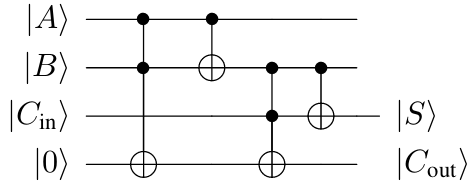

Since the qubit of our interest is already an ancilla, it is not necessary to copy on another qubit its content, but we can simply apply a $Z$ gate followed by $U^{\dagger}_{f(x)}$ for completing the design of the phase oracle. In the following cells the full-adder circuit is created and then exported as an instruction to be exploited in the circuit of the phase oracle.

In [ ]:
inputsFullAdder = QuantumRegister(3, 'qIn')
ancilla = QuantumRegister(1, 'ancilla') # it stores c_out
fullAdder = QuantumCircuit(inputsFullAdder, ancilla)
fullAdder.ccx(inputsFullAdder[0], inputsFullAdder[1], ancilla)
fullAdder.cx(inputsFullAdder[0], inputsFullAdder[1])
fullAdder.ccx(inputsFullAdder[1], inputsFullAdder[2], ancilla)
fullAdder.cx(inputsFullAdder[1], inputsFullAdder[2])

fullAdder_inst = fullAdder.to_instruction() # instruction exploitable in the following 

display(fullAdder.draw(output='mpl'))

In [ ]:
numbers = QuantumRegister(3, 'numIn')
ancilla = QuantumRegister(1, 'ancilla')
qc = QuantumCircuit(numbers, ancilla)

qc.h(numbers) # evaluate all inputs at the same time
qc.append(fullAdder_inst, list(numbers) + list(ancilla)) # append a full-adder circuit
qc.z(ancilla)
qc.append(fullAdder_inst.inverse(), list(numbers) + list(ancilla)) # append a full-adder inverse circuit

backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend).result()
sv = result.get_statevector()

'''states with non-null probability amplitudes are stored in a dictionary then printed'''

svDict = {}

for k in range(len(sv)):
    svDict["{0:03b}".format(k)] = sv[k]

filterDict = dict(filter(lambda elem: np.abs(elem[1]) > 0, svDict.items()))

print(filterDict)

# Conclusions #

An overview of techniques for oracle design has been introduced. It is to be hoped that these methodologies can be exploited in specific cases: as written in the introduction, many quantum algorithms require oracles.

It is important to precise that the methodology is based on the assumption that quantum computers are fully-connected, *i.e.* each qubit can be linked to the others via-CX gates. If this condition is not satisfied, transpiling procedures must be applied on the quantum circuit in order to have an equivalent circuit which can be executed on a real device. Moreover, the design of complex oracles involving many quantum gates can be affected by non-ideality phenomena as relaxation and decoherence.